In [1]:
import numpy as np
import pandas as pd

# Mounting Google Drive

import os
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
##### Importing all Libraries and Packages

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import random
random.seed(123)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
import cv2
import datetime
import itertools

from PIL import Image
import keras
from keras.preprocessing.image import load_img, ImageDataGenerator, img_to_array
from keras import models
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras import optimizers
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications import VGG19

from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import auc,roc_curve,roc_auc_score

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [4]:
#setting the data directory path
data_directory = '/content/drive/My Drive/chest_xray/'
train_data = data_directory + 'train/'
test_data = data_directory + 'test/'
val_data = data_directory + 'val/'

#training the dataset
training_normal = train_data + 'NORMAL/'
training_pneum = train_data + 'PNEUMONIA/'

#test the  dataset
testing_normal = test_data + 'NORMAL/'
testing_pneum = test_data + 'PNEUMONIA/'

#validation of the dataset
validating_normal = val_data + 'NORMAL/'
validating_pneum = val_data + 'PNEUMONIA/'

In [5]:
#checking the number of images in each dataset
#condition is normal
print('Train Normal:', len(os.listdir(training_normal)))
print('Test Normal:', len(os.listdir(testing_normal)))
print('Val Normal:', len(os.listdir(validating_normal)))
print('\n')

#pneumonia condition
print('Train Pneumonia:', len(os.listdir(training_pneum)))
print('Test Pneumonia:', len(os.listdir(testing_pneum)))
print('Val Pneumonia:', len(os.listdir(validating_pneum)))

Train Normal: 1341
Test Normal: 234
Val Normal: 8


Train Pneumonia: 3875
Test Pneumonia: 390
Val Pneumonia: 8


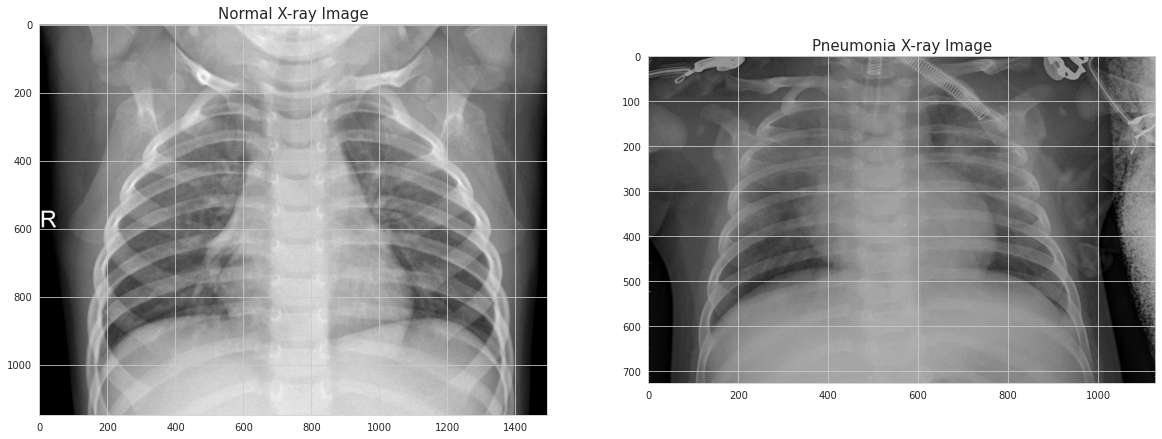

In [6]:
from PIL import Image
from keras.preprocessing.image import load_img
import matplotlib.pyplot as plt

normal = Image.open(training_normal + os.listdir(training_normal)[0])
pneum = Image.open(training_pneum + os.listdir(training_pneum)[0])

fig = plt.figure(figsize = (20, 20))

ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title('Normal X-ray Image', fontsize = 15)
plt.imshow(normal, cmap = 'gray')

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title('Pneumonia X-ray Image', fontsize = 15)
plt.imshow(pneum, cmap = 'gray')

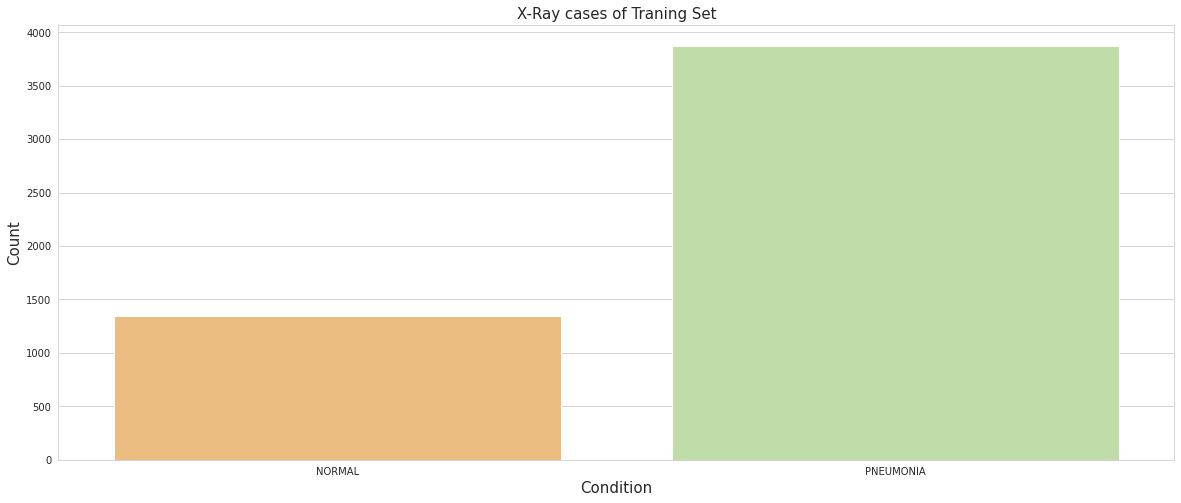

In [7]:
#visualize each class
import seaborn as sns

plt.figure(figsize = (20, 8))
sns.barplot(x = ['NORMAL', 'PNEUMONIA'], 
            y = [len(os.listdir(training_normal)), len(os.listdir(training_pneum))],
            palette = 'Spectral')
plt.xlabel('Condition', fontsize = 15)
plt.ylabel('Count', fontsize = 15)
plt.title('X-Ray cases of Traning Set', fontsize = 15);

In [8]:
#Data Augmentation

#Aim to increasing number of images to increase the train and validation data set to prevent overfitting

training_augment = ImageDataGenerator(rescale = 1./255,
                                   
                                   #randomly rotate images
                                   rotation_range = 40,
                                   
                                   #randomly shear angles
                                   shear_range = 0.2,
                                   
                                   #randomly zoom images
                                   zoom_range = 0.2,
                                   
                                   #randomly shift images
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   
                                   # randomly flip images
                                   horizontal_flip = True,
                                   
                                   fill_mode = 'nearest')

validating_augment = ImageDataGenerator(rescale = 1./255,
                                 rotation_range = 40,
                                 shear_range = 0.2,
                                 zoom_range = 0.2,
                                 width_shift_range = 0.2,
                                 height_shift_range = 0.2,
                                 horizontal_flip = True,
                                 fill_mode = 'nearest')

#Since real data isn't augmented, rescale the test dataset without augmentation.

testing_augment = ImageDataGenerator(rescale = 1./255)

In [9]:
#Obtain all of the data in the directory, with batch sizes and image measurements defined.
training_generator = training_augment.flow_from_directory(
        #target data directory 
        train_data,
    
        #resize to 150x150
        target_size = (150, 150),
    
        #data size batches
        batch_size = 32,
    
        #We need binary labels because we're using binary crossentropy failure.
        class_mode = 'binary')

testing_generator = testing_augment.flow_from_directory(test_data,
                                                  target_size = (150, 150),
                                                  batch_size = 32,
                                                  class_mode = 'binary',
                                                  shuffle = False)

validating_generator = validating_augment.flow_from_directory(val_data,
                                                target_size = (150, 150),
                                                batch_size = 32,
                                                class_mode = 'binary')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [10]:
import cv2
def picture_separation(folder):
    
    #Dividing the mixed images into NORMAL and PNEUMONIA categories and mark them accordingly.
    
    X = []
    y = []
    image_list = []

    for foldername in os.listdir(folder):
        if not foldername.startswith('.'):
            if foldername == "NORMAL":
                label = 0
            elif foldername == "PNEUMONIA":
                label = 1
            else:
                label = 2
                
            for image_filename in os.listdir(folder + "/"+ foldername):
                img_file = cv2.imread(folder + "/" + foldername + '/' + image_filename,0)               
                

                if img_file is not None:
                    img = cv2.resize(img_file,(64,64))
                    img_arr = img_to_array(img) / 255
                    X.append(img_arr)
                    y.append(label)
                    image_list.append(foldername + '/' + image_filename)
                                        
    X = np.asarray(X)
    y = np.asarray(y)
    
    return X, y, image_list

In [11]:
#getting the train dataset
X_train, y_train, img_train = picture_separation(train_data)

train_da = pd.DataFrame(img_train, columns = ["images"])
train_da["target"] = y_train

# Data preview
train_da.head()

,images,target
0,NORMAL/NORMAL2-IM-0917-0001.jpeg,0
1,NORMAL/NORMAL2-IM-0523-0001.jpeg,0
2,NORMAL/NORMAL2-IM-1253-0001.jpeg,0
3,NORMAL/IM-0235-0001.jpeg,0
4,NORMAL/NORMAL2-IM-0568-0001.jpeg,0


In [12]:
# getting the validation dataset
X_val, y_val, img_val = picture_separation(val_data)

val_da = pd.DataFrame(img_val, columns = ["images"])
val_da["target"] = y_val

# Data preview
val_da.head()

,images,target
0,NORMAL/NORMAL2-IM-1436-0001.jpeg,0
1,NORMAL/NORMAL2-IM-1437-0001.jpeg,0
2,NORMAL/NORMAL2-IM-1440-0001.jpeg,0
3,NORMAL/NORMAL2-IM-1427-0001.jpeg,0
4,NORMAL/NORMAL2-IM-1438-0001.jpeg,0


In [13]:
#get test dataset
X_test, y_test, img_test = picture_separation(test_data)

test_da = pd.DataFrame(img_test, columns = ["images"])
test_da["target"] = y_test

#preview
test_da.head()

,images,target
0,NORMAL/IM-0016-0001.jpeg,0
1,NORMAL/IM-0011-0001.jpeg,0
2,NORMAL/NORMAL2-IM-0132-0001.jpeg,0
3,NORMAL/IM-0084-0001.jpeg,0
4,NORMAL/IM-0027-0001.jpeg,0


In [14]:
#merging train, test and validation data to get the full dataset
fullData = pd.concat([train_da, test_da, val_da], axis = 0, ignore_index = True)
fullData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   images  5856 non-null   object
 1   target  5856 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 91.6+ KB


In [15]:
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('\n')

print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)
print('\n')

print('X_val shape:', X_val.shape)
print('y_val shape:', y_val.shape)

X_train shape: (5216, 64, 64, 1)
y_train shape: (5216,)


X_test shape: (624, 64, 64, 1)
y_test shape: (624,)


X_val shape: (16, 64, 64, 1)
y_val shape: (16,)


In [16]:
#reshaping from (64, 64), a 64x64 matrix, to (4096,), a 4096-element vector.

X_train = X_train.reshape(5216, 64*64).astype('float32')
X_test = X_test.reshape(624, 64*64).astype('float32')
X_val = X_val.reshape(16, 64*64).astype('float32')

In [17]:
#recheck
print('shape of X_train:', X_train.shape)
print('shape of X_test:', X_test.shape)
print('shape of X_val:', X_val.shape)

shape of X_train: (5216, 4096)
shape of X_test: (624, 4096)
shape of X_val: (16, 4096)


**Applying Convolutional Neural Network Model(CNN)**

In [ ]:
#from keras.callbacks import EarlyStopping, ModelCheckpoint

#specify the callbacks
#early_stopping = [EarlyStopping(monitor = 'val_loss', patience = 10, verbose = 1),
                 ModelCheckpoint(filepath = 'cnn_model.h5', monitor = 'val_loss', save_best_only = True)]

In [19]:
from keras.callbacks import ReduceLROnPlateau

In [20]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)


In [21]:
from keras.layers import Dropout, Flatten
from keras import regularizers

#initializing
cnn_model = models.Sequential()

#model architecture defining
cnn_model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)))
cnn_model.add(MaxPooling2D((2, 2)))

cnn_model.add(Conv2D(32, (3, 3), activation = 'relu'))
cnn_model.add(MaxPooling2D((2, 2)))

#fully connected layer
cnn_model.add(Flatten())
cnn_model.add(Dense(64, activation = 'relu'))
cnn_model.add(Dense(128, activation = 'relu'))

#one layer activated by sigmoid
cnn_model.add(Dense(1, activation = 'sigmoid'))

In [22]:
#compiling
cnn_model.compile(loss = 'binary_crossentropy',
                  optimizer = keras.optimizers.Adam(0.0001),
                  metrics = ['acc'])

In [23]:
#getting summary

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 41472)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                2654272   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8

In [25]:
# setting the time to check the time taken by model
start = datetime.datetime.now()

#fitting the model
cnn_history = cnn_model.fit(training_generator,
                            steps_per_epoch = 5216 // 32,
                            epochs = 12,
                            validation_data = testing_generator,
                            validation_steps = 624 // 32,
                            callbacks = [learning_rate_reduction])

Epoch 1/12
163/163 [==============================] - 116s 510ms/step - loss: 0.5809 - acc: 0.7368 - val_loss: 0.5617 - val_acc: 0.7253
Epoch 2/12
163/163 [==============================] - 82s 505ms/step - loss: 0.4429 - acc: 0.7989 - val_loss: 0.4341 - val_acc: 0.8026
Epoch 3/12
163/163 [==============================] - 85s 519ms/step - loss: 0.3397 - acc: 0.8511 - val_loss: 0.3717 - val_acc: 0.8322
Epoch 4/12
163/163 [==============================] - 84s 516ms/step - loss: 0.3111 - acc: 0.8588 - val_loss: 0.4982 - val_acc: 0.8059
Epoch 5/12
163/163 [==============================] - 84s 513ms/step - loss: 0.3299 - acc: 0.8533 - val_loss: 0.3417 - val_acc: 0.8536
Epoch 6/12
163/163 [==============================] - 84s 515ms/step - loss: 0.2761 - acc: 0.8766 - val_loss: 0.4189 - val_acc: 0.8421
Epoch 7/12
163/163 [==============================] - 83s 512ms/step - loss: 0.2687 - acc: 0.8891 - val_loss: 0.3187 - val_acc: 0.8651
Epoch 8/12
163/163 [==============================] - 

In [28]:
#total time taken
end = datetime.datetime.now()
elapsed = end - start
print('To complete the Training it took a total of {}'.format(elapsed))


To complete the Training it took a total of 0:17:50.230105


Model Evaluation

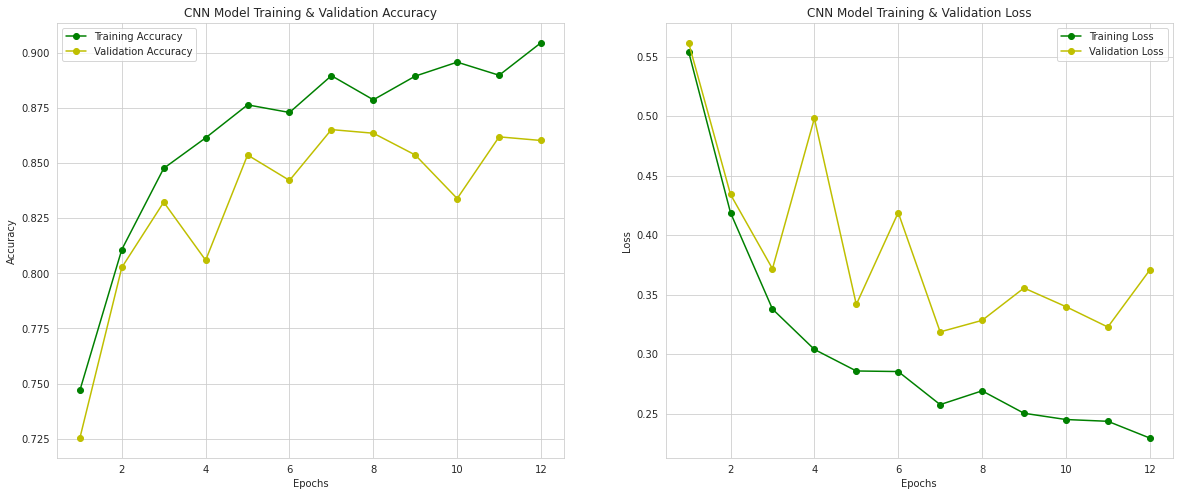

In [29]:
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20, 8)

cnn_train_acc = cnn_history.history['acc']
cnn_train_loss = cnn_history.history['loss']
cnn_val_acc = cnn_history.history['val_acc']
cnn_val_loss = cnn_history.history['val_loss']

epochs = range(1, len(cnn_train_acc) + 1)

ax[0].plot(epochs , cnn_train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , cnn_val_acc , 'yo-' , label = 'Validation Accuracy')
ax[0].set_title('CNN Model Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , cnn_train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , cnn_val_loss , 'yo-' , label = 'Validation Loss')
ax[1].set_title('CNN Model Training & Validation Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()

In [30]:
#evaluating training and testing 

print('Training loss & accuracy:' , cnn_model.evaluate(training_generator))
print('\n')
print('Testing loss & accuracy:' , cnn_model.evaluate(testing_generator))

163/163 [==============================] - 75s 461ms/step - loss: 0.2309 - acc: 0.8974
Training loss & accuracy: [0.23094752430915833, 0.897430956363678]


20/20 [==============================] - 6s 270ms/step - loss: 0.3633 - acc: 0.8638
Testing loss & accuracy: [0.36332762241363525, 0.8637820482254028]


In [31]:
########### importing the  Confusion Matric Class
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Blues):
    
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    plt.grid(b = None)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 fontsize = 12,
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[163  71]
 [ 14 376]]


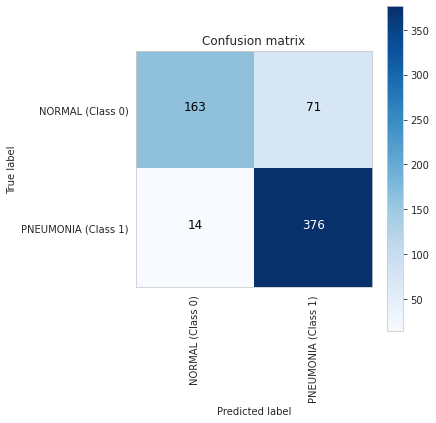

In [34]:
#defining target for testing
y_test = testing_generator.classes

#prediction Making
prediction = cnn_model.predict_classes(testing_generator)

#getting confusion matrix
cm = confusion_matrix(y_test, prediction)
print(cm)

#plotting the confusion matrix
plot_confusion_matrix(cm, classes = ['NORMAL (Class 0)','PNEUMONIA (Class 1)'], normalize = False)


In [35]:
#classification report of the model

print('Model: CNN', '\n', classification_report(y_test, prediction, target_names = ['NORMAL (Class 0)','PNEUMONIA (Class 1)']))

Model: CNN 
                      precision    recall  f1-score   support

   NORMAL (Class 0)       0.92      0.70      0.79       234
PNEUMONIA (Class 1)       0.84      0.96      0.90       390

           accuracy                           0.86       624
          macro avg       0.88      0.83      0.85       624
       weighted avg       0.87      0.86      0.86       624



AUC: 0.8303418803418804


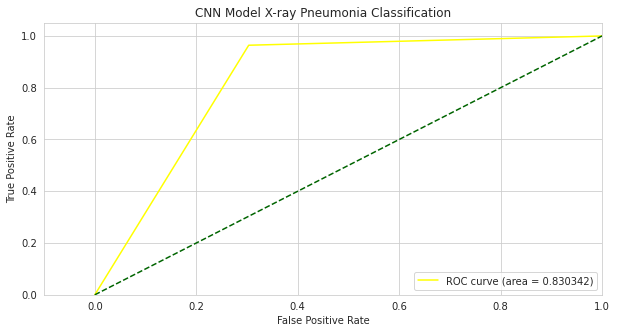

In [37]:
fpr, tpr, thresholds = roc_curve(y_test, prediction)
auc = roc_auc_score(y_test, prediction)
print('AUC:', auc)

plt.figure(figsize = (10, 5))
plt.plot(fpr, tpr, color = 'yellow', label = 'ROC curve (area = %f)' % auc)
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'darkgreen')
plt.xlim([-0.1, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CNN Model X-ray Pneumonia Classification')
plt.legend(loc = "lower right")
plt.show()

## **Transfer Learning**

In [38]:
#initializing the  base CNN Model
from keras.applications import VGG16

cnn_base = VGG16(include_top = False,
                 weights = 'imagenet',
                 input_shape = (150, 150, 3),
                 classes = 2,
                 classifier_activation = 'sigmoid')

58892288/58889256 [==============================] - 0s 0us/step


In [39]:
# Pretrained model is kept frozen to avoid the weights getting updated in a given layer while traning.

cnn_base.trainable = False

In [40]:
# model architecture defining
pretrainedCNN_model = models.Sequential()

pretrainedCNN_model.add(cnn_base)

#fully connected layer
pretrainedCNN_model.add(layers.Flatten())

pretrainedCNN_model.add(Dense(640, activation = 'relu'))
pretrainedCNN_model.add(Dropout(0.5))
pretrainedCNN_model.add(Dense(128, activation = 'relu'))
pretrainedCNN_model.add(Dropout(0.5))

#output layer
pretrainedCNN_model.add(layers.Dense(1, activation = 'sigmoid'))

In [41]:
#check the layer is trainable or not.
for layer in pretrainedCNN_model.layers:
    print(layer.name, layer.trainable)

vgg16 False
flatten_1 True
dense_3 True
dropout True
dense_4 True
dropout_1 True
dense_5 True


In [42]:
#compiling
pretrainedCNN_model.compile(loss = 'binary_crossentropy',
                            optimizer = keras.optimizers.Adam(0.0001),
                            metrics = ['acc'])

In [43]:
#summary
pretrainedCNN_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 640)               5243520   
_________________________________________________________________
dropout (Dropout)            (None, 640)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               82048     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [44]:
# setting the time to check the time taken by model
start = datetime.datetime.now()

#fit
pretrained_VGG16 = pretrainedCNN_model.fit(training_generator,
                                                steps_per_epoch = 5216 // 32,
                                                epochs = 12,
                                                validation_data = testing_generator,
                                                validation_steps = 624 // 32,
                                                callbacks = [learning_rate_reduction])


Epoch 1/12
163/163 [==============================] - 90s 532ms/step - loss: 0.4957 - acc: 0.7721 - val_loss: 0.3250 - val_acc: 0.8750
Epoch 2/12
163/163 [==============================] - 86s 529ms/step - loss: 0.2687 - acc: 0.8795 - val_loss: 0.3109 - val_acc: 0.8684
Epoch 3/12
163/163 [==============================] - 86s 528ms/step - loss: 0.2325 - acc: 0.9069 - val_loss: 0.3130 - val_acc: 0.8832
Epoch 4/12
163/163 [==============================] - 86s 529ms/step - loss: 0.2213 - acc: 0.9026 - val_loss: 0.3239 - val_acc: 0.8750
Epoch 5/12
163/163 [==============================] - 86s 528ms/step - loss: 0.2042 - acc: 0.9140 - val_loss: 0.2913 - val_acc: 0.8898
Epoch 6/12
163/163 [==============================] - 86s 526ms/step - loss: 0.1896 - acc: 0.9203 - val_loss: 0.2759 - val_acc: 0.8997
Epoch 7/12
163/163 [==============================] - 85s 525ms/step - loss: 0.2064 - acc: 0.9244 - val_loss: 0.3208 - val_acc: 0.8914
Epoch 8/12
163/163 [==============================] - 8

In [45]:
#total time taken
end = datetime.datetime.now()
elapsed = end - start
print('To complete the Training it took a total of {}'.format(elapsed))

To complete the Training it took a total of 0:17:39.599193


Model Evaluation

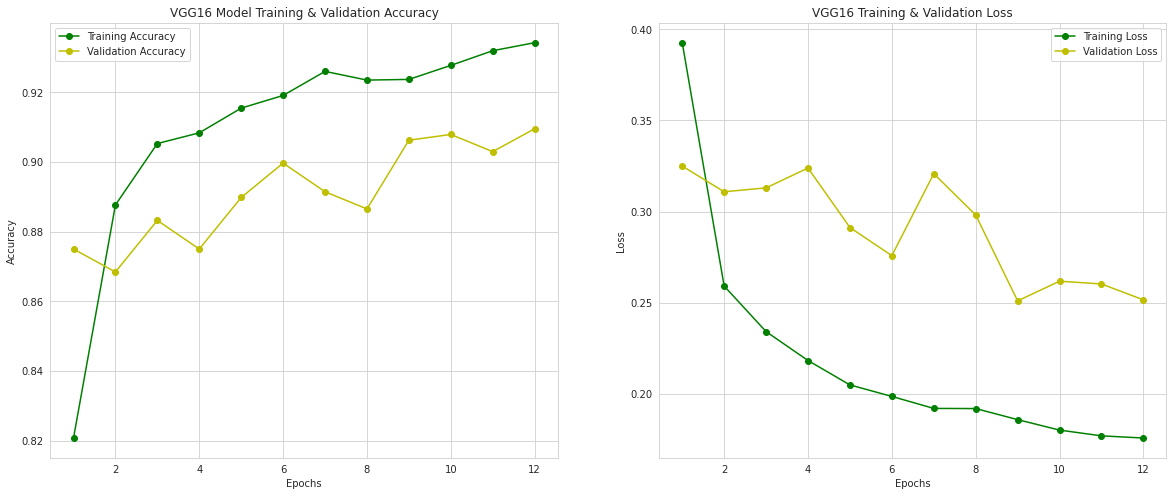

In [47]:
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20, 8)

pretrainedCNN_train_acc = pretrained_VGG16.history['acc']
pretrainedCNN_train_loss = pretrained_VGG16.history['loss']
pretrainedCNN_val_acc = pretrained_VGG16.history['val_acc']
pretrainedCNN_val_loss = pretrained_VGG16.history['val_loss']

epochs = range(1, len(pretrainedCNN_train_acc) + 1)

ax[0].plot(epochs , pretrainedCNN_train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , pretrainedCNN_val_acc , 'yo-' , label = 'Validation Accuracy')
ax[0].set_title('VGG16 Model Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , pretrainedCNN_train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , pretrainedCNN_val_loss , 'yo-' , label = 'Validation Loss')
ax[1].set_title('VGG16 Training & Validation Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()

In [48]:
print('Train loss & accuracy:' , pretrainedCNN_model.evaluate(training_generator))
print('\n')
print('Test loss & accuracy:' , pretrainedCNN_model.evaluate(testing_generator))

163/163 [==============================] - 79s 484ms/step - loss: 0.1431 - acc: 0.9473
Train loss & accuracy: [0.1430637091398239, 0.9472776055335999]


20/20 [==============================] - 8s 369ms/step - loss: 0.2457 - acc: 0.9119
Test loss & accuracy: [0.24568164348602295, 0.9118589758872986]


In [49]:
#make prediction
prediction = pretrainedCNN_model.predict_classes(testing_generator)

#get confusion matrix
cm = confusion_matrix(y_test, prediction)
print(cm)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[192  42]
 [ 13 377]]


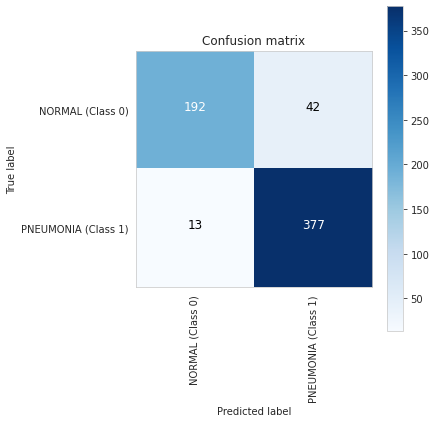

In [50]:
#plot confustion matrix
plot_confusion_matrix(cm, classes = ['NORMAL (Class 0)','PNEUMONIA (Class 1)'], normalize = False)

In [51]:
#get classification report

print('Model: VGG16 CNN Model', '\n', classification_report(y_test, prediction, target_names = ['NORMAL (Class 0)','PNEUMONIA (Class 1)']))

Model: VGG16 CNN Model 
                      precision    recall  f1-score   support

   NORMAL (Class 0)       0.94      0.82      0.87       234
PNEUMONIA (Class 1)       0.90      0.97      0.93       390

           accuracy                           0.91       624
          macro avg       0.92      0.89      0.90       624
       weighted avg       0.91      0.91      0.91       624



AUC: 0.8935897435897436


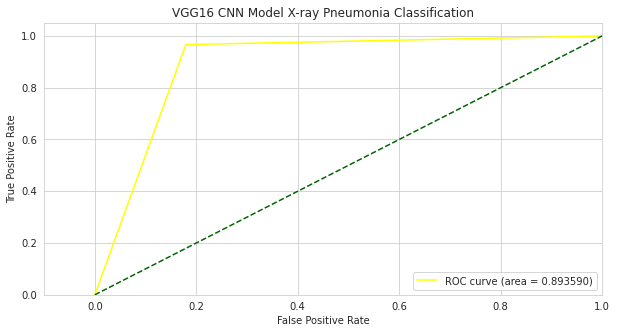

In [52]:
fpr, tpr, thresholds = roc_curve(y_test, prediction)
auc = roc_auc_score(y_test, prediction)
print('AUC:', auc)

plt.figure(figsize = (10, 5))
plt.plot(fpr, tpr, color = 'yellow', label = 'ROC curve (area = %f)' % auc)
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'darkgreen')
plt.xlim([-0.1, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('VGG16 CNN Model X-ray Pneumonia Classification')
plt.legend(loc = "lower right")
plt.show()

In [53]:
# Correctly Predicted Classes
correct = np.nonzero(yhat_test == y_test)[0]


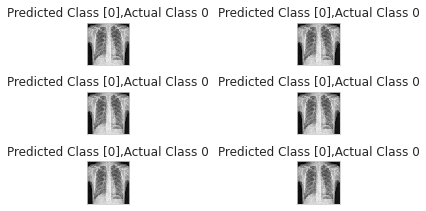

In [55]:
# Getting some Correctly Predicted Classes

i = 0
for c in correct[:6]:
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[c].reshape(64, 64), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(yhat_test[c], y_test[c]))
    plt.tight_layout()
    i += 1